In [3]:
import os
import argparse
import json
import time
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from src.models import TemporalPC, MultilayertPC
from src.utils import *
from src.get_data import *
import matplotlib as mpl

In [ ]:
def train_PC(model, optimizer, seq, learn_iters, inf_iters, inf_lr, device, batchsize = 1):
    seq_len = seq.shape[0]
    losses = []
    start_time = time.time()
    for learn_iter in range(learn_iters):
        epoch_loss = 0
        prev_z = model.init_hidden(batchsize).to(device)
        for k in range(seq_len):
            x = seq[k].clone().detach()
            optimizer.zero_grad()
            model.inference(inf_iters, inf_lr, x, prev_z)
            energy = model.update_grads(x, prev_z)
            energy.backward()
            optimizer.step()
            prev_z = model.z.clone().detach()

            # add up the loss value at each time step
            epoch_loss += energy.item() / seq_len

        losses.append(epoch_loss)
        if (learn_iter + 1) % 10 == 0:
            print(f'Epoch {learn_iter+1}, loss {epoch_loss}')
        
    print(f'training PC complete, time: {time.time() - start_time}')
    return losses

def _recall(model, seq, inf_iters, inf_lr, query, device):
    seq_len, N = seq.shape
    recall = torch.zeros((seq_len, N)).to(device)
    recall[0] = seq[0].clone().detach()
    prev_z = model.init_hidden(1).to(device)
    loss = 0
    
    if query == 'online':
        # infer the latent state at each time step, given correct previous input
        for k in range(seq_len-1):
            x = seq[k].clone().detach()
            model.inference(inf_iters, inf_lr, x, prev_z)
            prev_z = model.z.clone().detach()
            _, pred_x = model(prev_z)
            recall[k+1] = pred_x
            energy = model.update_grads(x, prev_z)
            loss += energy.item() / seq_len

    elif query == 'offline':
        # only infer the latent of the cue, then forward pass
        x = seq[0].clone().detach()
        model.inference(inf_iters, inf_lr, x, prev_z)
        prev_z = model.z.clone().detach()

        # fast forward pass
        for k in range(1, seq_len):
            x = seq[k].clone().detach()
            prev_z, pred_x = model(prev_z)
            recall[k] = pred_x
            energy = model.update_grads(x, prev_z)
            loss += energy.item() / seq_len

    return recall, loss

In [5]:
def seq2onehot(seq, num_classes, num_reps = 6):
    L = len(seq)
    t = torch.empty(L, num_reps*num_classes)
    for i,s in enumerate(seq):
        t[i,:] = nn.functional.one_hot(torch.tensor([s]), num_classes= num_classes).repeat(1,6).flatten()
    return t
        
def recall2class(onehot, num_classes, num_reps = 6):
    recall = []
    for s in onehot:
        r = torch.argmax(s[:num_classes]).detach().item()
        recall.append(r)
    return recall

In [52]:
# sequences
num_classes = 8
num_reps = 6

seq = [1,2,7,4,5,7]
seq1 = seq2onehot(seq, num_classes)

seq = [7,2,3,7,5,6]
seq2 = seq2onehot(seq, num_classes)


# seq = [1,2,0,4,5,0]
# seqt1 = seq2onehot(seq, num_classes)
# seq = [2,3,0,5,6,0]
# seqt2 = seq2onehot(seq, num_classes)
seq = [1,2,3]
seqt1 = seq2onehot(seq, num_classes)
seq = [4,5,6]
seqt2 = seq2onehot(seq, num_classes)


In [74]:
seq1.size()

tt = torch.stack([seq1,seq2])
tt.size()

torch.Size([2, 6, 48])

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

batchsize = 2
num_cues = seq1[0].size()[0]
seq_len = seq1.size()[0]
inf_iters = 5 # for this experiment inf iters too large is harmful
inf_lr = 0.01
learn_iters = 200
learn_lr = 0.01
latent_size = 8
input_size = num_cues
control_size = num_cues
sparse_penal = 0
n_cued = 1 # number of cued images
assert(n_cued < seq_len)

torch.manual_seed(1)

cpu


In [66]:
model = MultilayertPC(latent_size, input_size, nonlin='tanh').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learn_lr)

# PC_losses1 = train_PC(model, optimizer, seq1, 100, inf_iters, inf_lr, device)
PC_losses1 = train_PC(model, optimizer, tt, 100, inf_iters, inf_lr, device, batchsize)
# PC_losses2 = train_PC(model, optimizer, seq2, 40, inf_iters, inf_lr, device)

RuntimeError: The size of tensor a (6) must match the size of tensor b (2) at non-singleton dimension 0

In [79]:
x.size()

torch.Size([6, 48])

In [76]:
seq=tt
seq_len = seq.shape[1]
losses = []
start_time = time.time()
for learn_iter in range(learn_iters):
    epoch_loss = 0
    prev_z = model.init_hidden(batchsize).to(device)
    for k in range(seq_len):
        x = seq[k].clone().detach()
        optimizer.zero_grad()
        model.inference(inf_iters, inf_lr, x, prev_z)
        energy = model.update_grads(x, prev_z)
        energy.backward()
        optimizer.step()
        prev_z = model.z.clone().detach()

        # add up the loss value at each time step
        epoch_loss += energy.item() / seq_len

    losses.append(epoch_loss)
    if (learn_iter + 1) % 10 == 0:
        print(f'Epoch {learn_iter+1}, loss {epoch_loss}')


RuntimeError: The size of tensor a (6) must match the size of tensor b (2) at non-singleton dimension 0

In [72]:
prev_z.size()

torch.Size([2, 8])

In [73]:
x.size()

torch.Size([6, 48])

Text(0, 0.5, 'Loss')

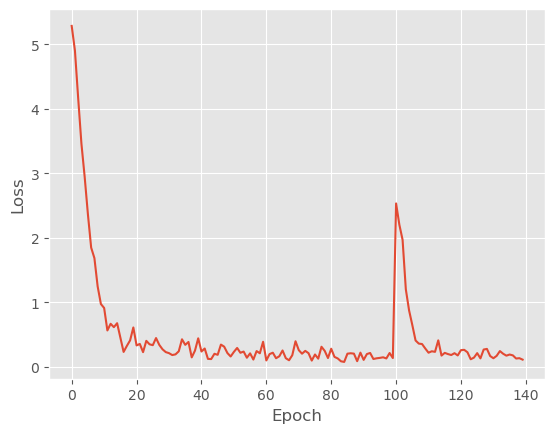

In [46]:
plt.plot(PC_losses1+PC_losses2)
plt.xlabel('Epoch')
plt.ylabel('Loss')

[4, 5, 6]
[4, 5, 6]
[4, 5, 6]


Text(0, 0.5, 'time step')

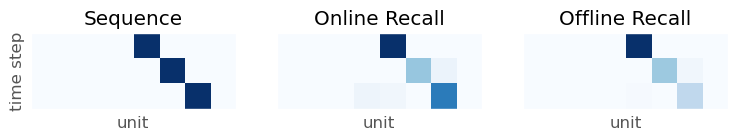

In [55]:
seq = [4,5,6]
#seq = [1,2,3]
seqt = seq2onehot(seq, num_classes)
test = seqt

model.eval()
inf_iters = 200
query = 'online'
with torch.no_grad():
    online_recall,_ = _recall(model, test, inf_iters, inf_lr, query, device)
query = 'offline'
with torch.no_grad():
    offline_recall,_ = _recall(model, test, inf_iters, inf_lr, query, device)

norm = mpl.colors.Normalize(vmin=0, vmax=1)
fig, ax = plt.subplots(1,3, figsize =(9,5))

ax[0].imshow(test.detach().numpy()[:,:num_classes], cmap='Blues', norm=norm)
ax[0].set_title('Sequence')
print(torch.argmax(test, axis=1).detach().numpy().tolist())

ax[1].imshow(online_recall.detach().numpy()[:,:num_classes], cmap='Blues', norm=norm)
print(recall2class(online_recall, num_classes,num_reps))
ax[1].set_title('Online Recall')

ax[2].imshow(offline_recall.detach().numpy()[:,:num_classes], cmap='Blues', norm=norm)
print(recall2class(offline_recall, num_classes,num_reps))
ax[2].set_title('Offline Recall')

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel('unit')
ax[0].set_ylabel('time step')